# Forecasting Bike Rides with fbprophet

## Challanges

## Library and Data

We are using a riding data created by Leif Arne Bakker that can be downloaded here https://github.com/pixelbakker/datasets/blob/master/bikerides_day.csv

In [13]:
import pandas as pd
import numpy as np
import itertools
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import plotly.offline as pyoff
import plotly.graph_objs as go
from sklearn import preprocessing
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from scipy.stats import boxcox
from scipy.special import inv_boxcox
pd.set_option('display.max_row', 1000)

# Read the data
bikerides = pd.read_csv('data/bikerides_day.csv', error_bad_lines=False, encoding= 'unicode_escape', delimiter=',')
# Convert Date to datetime
bikerides['Date'] = pd.to_datetime(bikerides['Date'])

# Shows the data
display(bikerides.head(5))
display(bikerides.tail(5))

Date  Volume  Rain  Temp
0 2016-11-17   933.0   9.0   2.1
1 2016-11-18  1197.0   6.7   3.9
2 2016-11-19   243.0   5.4   2.0
3 2016-11-20   234.0   3.9   2.8
4 2016-11-21  2148.0   7.3   2.8

Date  Volume  Rain  Temp
1268 2020-05-16  2484.0   0.0   6.6
1269 2020-05-17  1509.0   0.0   9.1
1270 2020-05-18  5775.0   0.0   9.3
1271 2020-05-19  6741.0   0.0   9.7
1272 2020-05-20  1647.0   0.0  10.8

As we can see, we have ride volume, rain, and temp in daily basis from 2016-11-17 to 2020-05-20.  
In this study we want to use fbprophet to forecast the ride volumes in the future. Hence we need to met certain criteria to use fbprophet.
1. We have to rename the time to 'ds'
2. We have to rename the variable that will be predicted to y

In [14]:
# Rename the columns to Prophet scheme who expect date column to be named "ds" and data column to called "y"
bikerides.columns = ['ds', 'y', 'rain', 'temp']
bikerides.head(1)

ds      y  rain  temp
0 2016-11-17  933.0   9.0   2.1

To get initial views of the trend, we can plot the time series data.

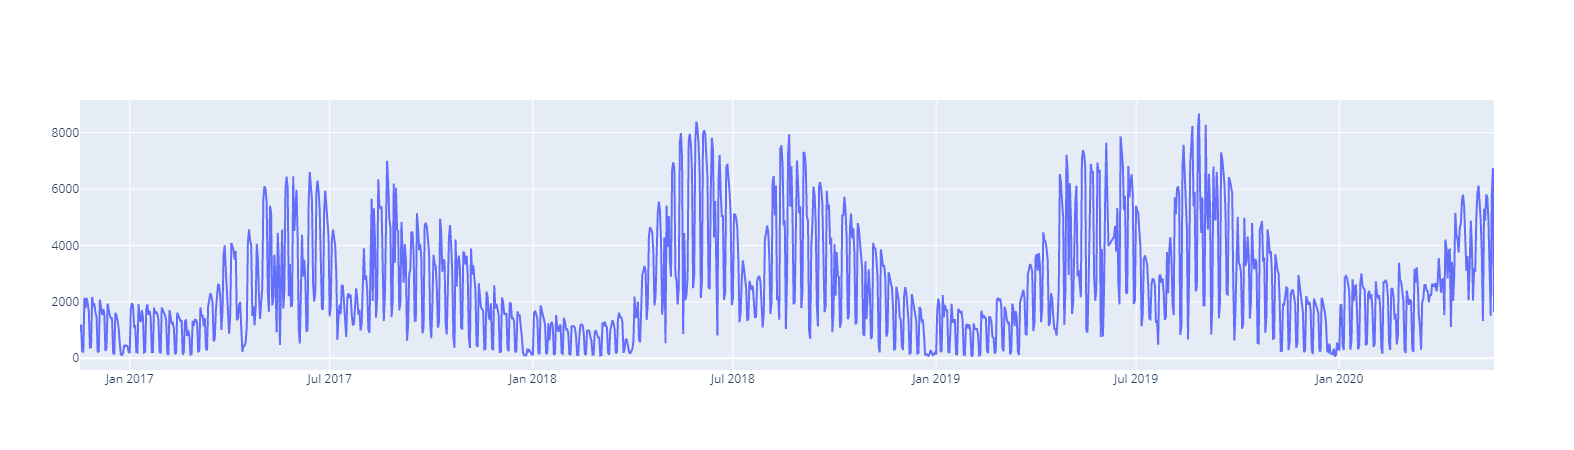

In [15]:
fig = go.Figure()
#Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Rides',))
fig.show()

## Data Processing

### Applying Box Cox transformation
For time-series it’s often useful to do some form of power transform of the data to stabilise variance and make the data more normal distribution-like. But what transformation to use for the best result? Fortunately, we can use a Box Cox transformation that evaluates a set of lambda coefficients (λ) and selects the value that achieves the best approximation of normality. We can do it like so:

In [16]:
# Apply Box-Cox Transform and save the lambda for later inverse.
bikerides['y'], lam = boxcox(bikerides['y'])
print('Lambda is:', lam)
display(bikerides.head())

Lambda is: 0.39785155933505256


ds          y  rain  temp
0 2016-11-17  35.667823   9.0   2.1
1 2016-11-18  39.646780   6.7   3.9
2 2016-11-19  19.842603   5.4   2.0
3 2016-11-20  19.509433   3.9   2.8
4 2016-11-21  50.689236   7.3   2.8

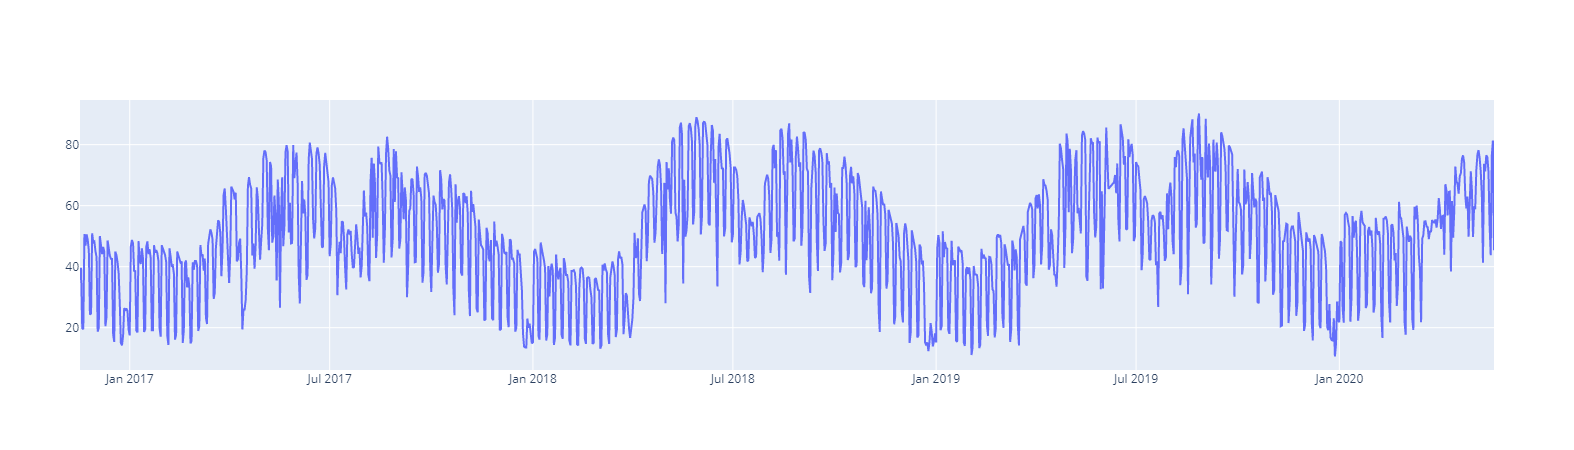

In [17]:
#Plot
fig = go.Figure()
#Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Rides',))
fig.show()

We can see that the variability reducing after we apply the boxcox

Now let see how rain and temp affect the ride volumes

In [20]:
# normalize data
scaler = preprocessing.MinMaxScaler()
bikerides_source = bikerides.set_index('ds')
bikerides_norm = scaler.fit_transform(bikerides_source)
bikerides_norm = pd.DataFrame(bikerides_norm,columns=bikerides_source.columns, index=bikerides_source.index)
bikerides_norm.reset_index(inplace=True)
bikerides_norm.head()

ds         y      rain      temp
0 2016-11-17  0.315277  0.227848  0.361930
1 2016-11-18  0.365225  0.169620  0.410188
2 2016-11-19  0.116619  0.136709  0.359249
3 2016-11-20  0.112436  0.098734  0.380697
4 2016-11-21  0.503844  0.184810  0.380697

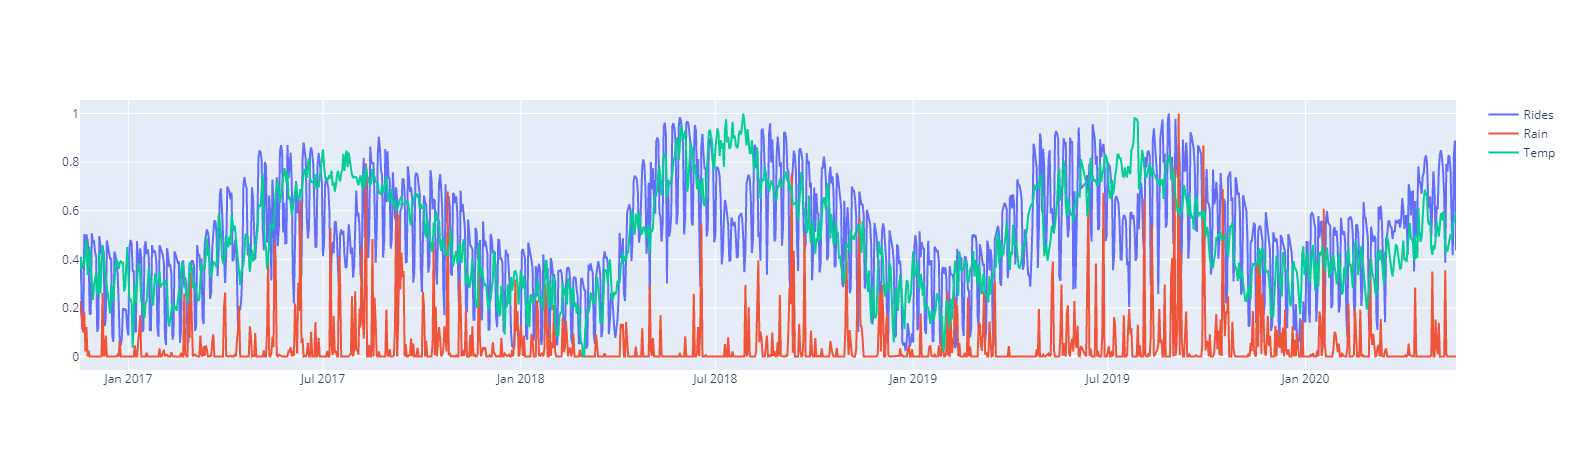

In [21]:
#Plot
fig = go.Figure()
#Create and style traces
fig.add_trace(go.Scatter(x=bikerides_norm['ds'], y=bikerides_norm['y'], name='Rides',))
fig.add_trace(go.Scatter(x=bikerides_norm['ds'], y=bikerides_norm['rain'], name='Rain',))
fig.add_trace(go.Scatter(x=bikerides_norm['ds'], y=bikerides_norm['temp'], name='Temp',))
fig.show()

Not surprisingly, the temperature is highly correlated to the commute volume. We see a break in the pattern in July most likely due to the Norwegian common holiday. When it comes to the rain it’s harder to draw any conclusions from the plot but when zooming in there are signs that rain might play a role. We’ll see.

Ok, it looks like we are ready to go. Let’s do some forecasting.

## Forecasting with prophet — a first take


The Prophet code flow is really simple: First get hold of a Prophet instance and fit a model with our bike rides data frame. Then we create a data frame holding the prediction dates (horizon) and pass that into the Prophet predict method, like so:

    

In [22]:
# Hyperparameters
PERIODS = 180
FREQ = 'D'

# Forecasting
m = Prophet()
 
# Fit the data. Remember that prophet expect "ds" and "y" as names for the columns.
m.fit(bikerides)
 
# We must create a data frame holding dates for our forecast. The periods # parameter counts days as long as the frequency is 'D' for the day. Let's # do a 180 day forecast, approximately half a year.
future = m.make_future_dataframe(periods=PERIODS, freq=FREQ)
# Create the forecast object which will hold all of the resulting data from the forecast.
forecast = m.predict(future)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [24]:
forecast.head()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2016-11-17  50.498492   37.411444   56.766715    50.498492    50.498492   
1 2016-11-18  50.490290   33.777039   54.391541    50.490290    50.490290   
2 2016-11-19  50.482087   13.572979   33.565790    50.482087    50.482087   
3 2016-11-20  50.473885   14.470594   34.487241    50.473885    50.473885   
4 2016-11-21  50.465683   39.651477   60.064308    50.465683    50.465683   

   additive_terms  additive_terms_lower  additive_terms_upper     weekly  \
0       -3.457707             -3.457707             -3.457707   5.879233   
1       -6.545268             -6.545268             -6.545268   2.929811   
2      -26.735609            -26.735609            -26.735609 -17.198031   
3      -25.751018            -25.751018            -25.751018 -16.218472   
4       -1.041213             -1.041213             -1.041213   8.428806   

   weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0      5.879233      5.879233 -9.336940     -9.336940     -9.336940   
1      2.929811      2.929811 -9.475079     -9.475079     -9.475079   
2    -17.198031    -17.198031 -9.537578     -9.537578     -9.537578   
3    -16.218472    -16.218472 -9.532546     -9.532546     -9.532546   
4      8.428806      8.428806 -9.470019     -9.470019     -9.470019   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper       yhat  
0                         0.0  47.040785  
1                         0.0  43.945022  
2                         0.0  23.746478  
3                         0.0  24.722867  
4                         0.0  49.424470

In [23]:
# List the predicted values with a lower and upper band
forecast.tail()

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1448 2020-11-12  59.855056   48.269831   68.628401    59.560972    60.122453   
1449 2020-11-13  59.868362   44.558349   64.839833    59.573198    60.137447   
1450 2020-11-14  59.881667   24.178488   44.740526    59.585068    60.155448   
1451 2020-11-15  59.894972   24.895084   43.959614    59.591442    60.171429   
1452 2020-11-16  59.908277   49.390655   69.075060    59.600659    60.189124   

      additive_terms  additive_terms_lower  additive_terms_upper     weekly  \
1448       -1.503298             -1.503298             -1.503298   5.879233   
1449       -5.012799             -5.012799             -5.012799   2.929811   
1450      -25.618245            -25.618245            -25.618245 -17.198031   
1451      -25.030532            -25.030532            -25.030532 -16.218472   
1452       -0.688370             -0.688370             -0.688370   8.428806   

      weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
1448      5.879233      5.879233 -7.382532     -7.382532     -7.382532   
1449      2.929811      2.929811 -7.942610     -7.942610     -7.942610   
1450    -17.198031    -17.198031 -8.420214     -8.420214     -8.420214   
1451    -16.218472    -16.218472 -8.812061     -8.812061     -8.812061   
1452      8.428806      8.428806 -9.117175     -9.117175     -9.117175   

      multiplicative_terms  multiplicative_terms_lower  \
1448                   0.0                         0.0   
1449                   0.0                         0.0   
1450                   0.0                         0.0   
1451                   0.0                         0.0   
1452                   0.0                         0.0   

      multiplicative_terms_upper       yhat  
1448                         0.0  58.351758  
1449                         0.0  54.855563  
1450                         0.0  34.263422  
1451                         0.0  34.864440  
1452                         0.0  59.219908

<ipython-input-25-d3965b29b9e5>:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

<ipython-input-25-d3965b29b9e5>:5: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



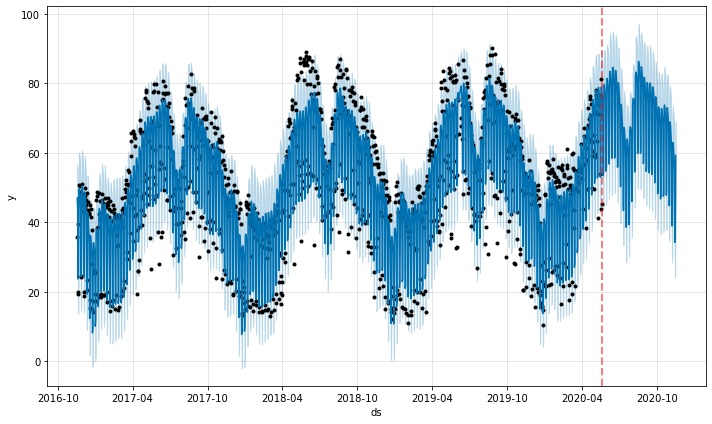

In [25]:
# Plotting with Prophet built-in method
fig = m.plot(forecast)
ax = fig.add_subplot(111)
ax.axvline(x=forecast['ds'].max() - pd.Timedelta('180 days'), c='red', lw=2, alpha=0.5, ls='--')
fig.show()

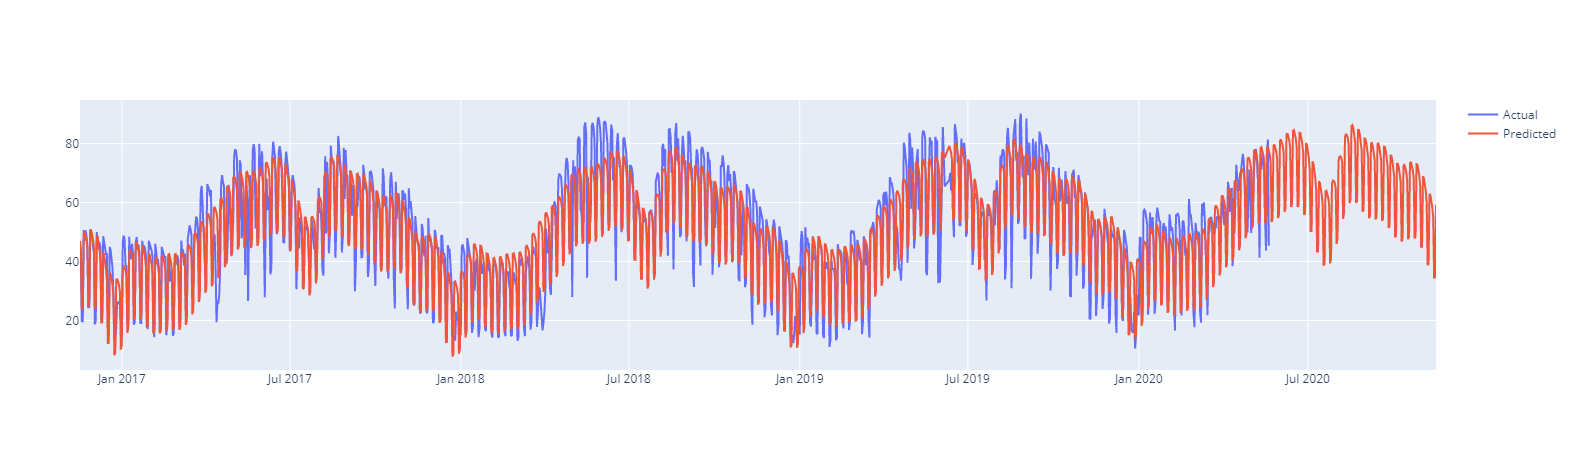

In [26]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.show()

<ipython-input-27-1f7e4c26d9df>:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

<ipython-input-27-1f7e4c26d9df>:5: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



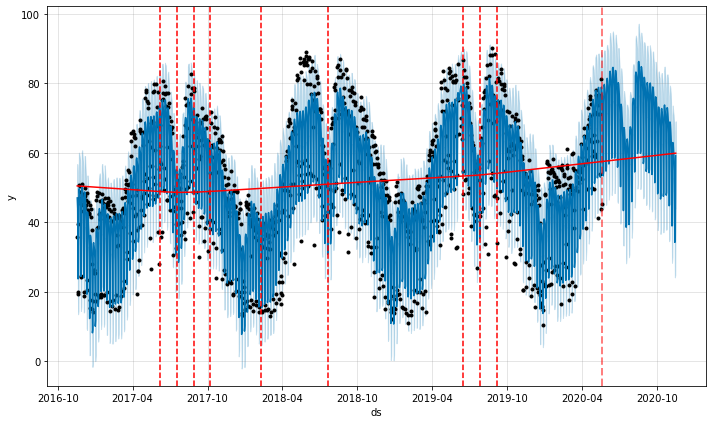

In [27]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
ax = fig.add_subplot(111)
ax.axvline(x=forecast['ds'].max() - pd.Timedelta('180 days'), c='red', lw=2, alpha=0.5, ls='--')
fig.show()

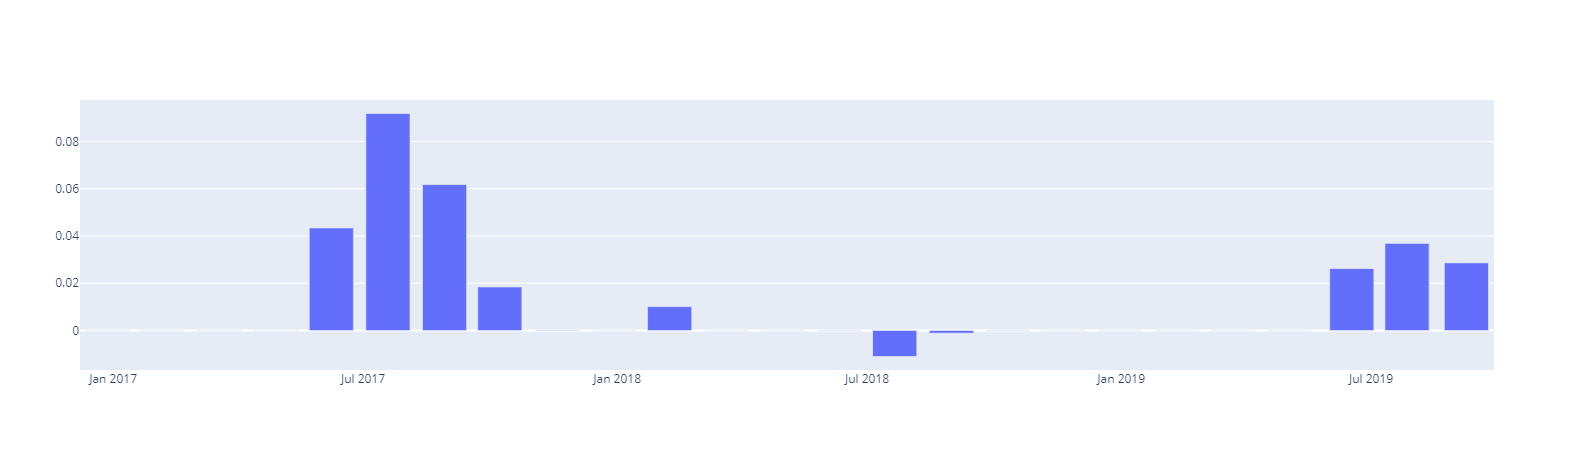

In [28]:
# Listing all the change points in the model
deltas = m.params['delta'].mean(0)
cp = pd.DataFrame(m.changepoints)
cp['deltas'] = deltas
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Bar(x=cp['ds'], y=cp['deltas'], name='CPs',))

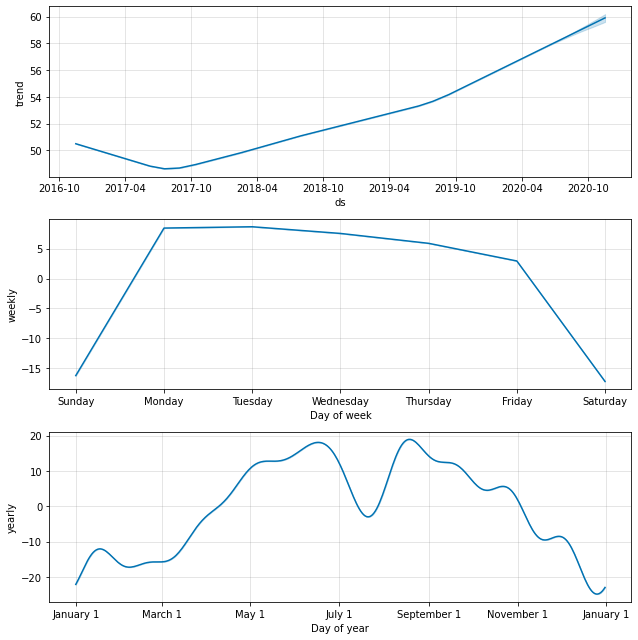

In [29]:
fig = m.plot_components(forecast)

INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00


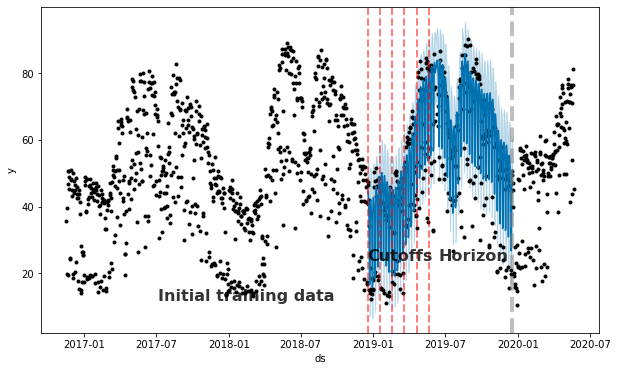

In [30]:
# Fit the model with two years of data and define a horizon of 365 days forcasting per month
df_cv = cross_validation(m, initial='730 days', period = '31 days', horizon = '365 days')
cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']
cutoff = df_cv['cutoff'].unique()[0]
df_cv = df_cv[df_cv['cutoff'].values == cutoff]

fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(m.history['ds'].values, m.history['y'], 'k.')
ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
                df_cv['yhat_upper'], color='#0072B2',
                alpha=0.2)
#ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')

# Making all the vlines for cutoffs
for item in cutoffs:
  ax.axvline(x=pd.to_datetime(item), c='red', lw=2, alpha=0.5, ls='--')

# Adding text to describe the data set splits
ax.text(x=pd.to_datetime('2017-07-07'),y=12, s='Initial training data', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)
ax.text(x=pd.to_datetime('2018-12-17'),y=24, s='Cutoffs', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.text(x=pd.to_datetime(cutoff) + pd.Timedelta('180 days'),y=24, s='Horizon', color='black',
       fontsize=16, fontweight='bold', alpha=0.8)

ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('365 days'), c='gray', lw=4,
           alpha=0.5, ls='--')

In [31]:
df_p = performance_metrics(df_cv)
df_p.head(5)

horizon         mse       rmse       mae      mape     mdape  coverage
0 36 days  135.707353  11.649350  7.863997  0.411784  0.105713       0.8
1 37 days  136.079931  11.665330  7.928461  0.413248  0.105713       0.8
2 38 days  136.001480  11.661967  7.906840  0.412616  0.105713       0.8
3 39 days  136.144583  11.668101  7.937703  0.413390  0.105713       0.8
4 40 days  138.051435  11.749529  8.103271  0.427295  0.133175       0.8

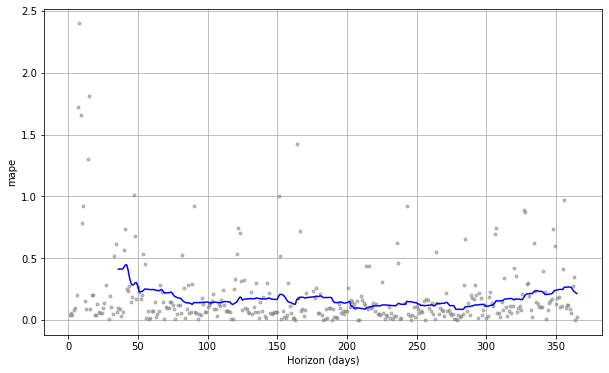

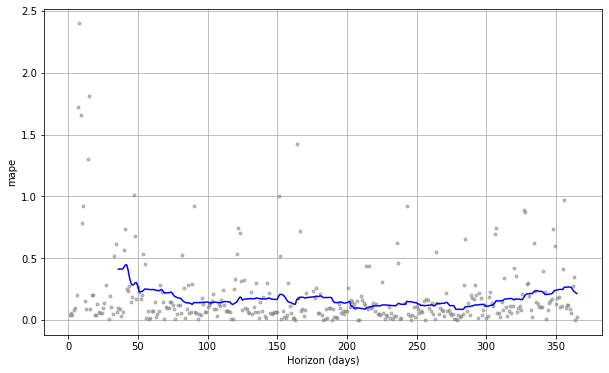

In [34]:
plot_cross_validation_metric(df_cv, metric='mape')

In [35]:
df_p.mean()

horizon     200 days 14:04:26.666666666
mse                             81.6034
rmse                            8.74448
mae                              6.7902
mape                           0.171827
mdape                         0.0995206
coverage                       0.795326
dtype: object

In [36]:
def getPerformanceMetrics(m):
  return performance_metrics(getCrossValidationData(m))

def getCrossValidationData(m):
 return cross_validation(m, initial='730 days', period = '31 days', horizon = '365 days')

In [37]:
m = Prophet()
m.add_country_holidays(country_name='NO')
m.fit(bikerides)
# List the holiday names
m.train_holiday_names

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0                    Søndag
1           Første påskedag
2           Arbeidernes dag
3           Første pinsedag
4            Første juledag
5         Første nyttårsdag
6              Grunnlovsdag
7             Andre juledag
8              Skjærtorsdag
9                Langfredag
10           Andre påskedag
11    Kristi himmelfartsdag
12           Andre pinsedag
dtype: object

In [38]:
# We must create a data frame holding dates for our forecast. The periods # parameter counts days as long as the frequency is 'D' for the day. Let's # do a 180 day forecast, approximately half a year.
future = m.make_future_dataframe(periods=PERIODS, freq=FREQ)
# Create the forecast object which will hold all of the resulting data from the forecast.
forecast = m.predict(future)

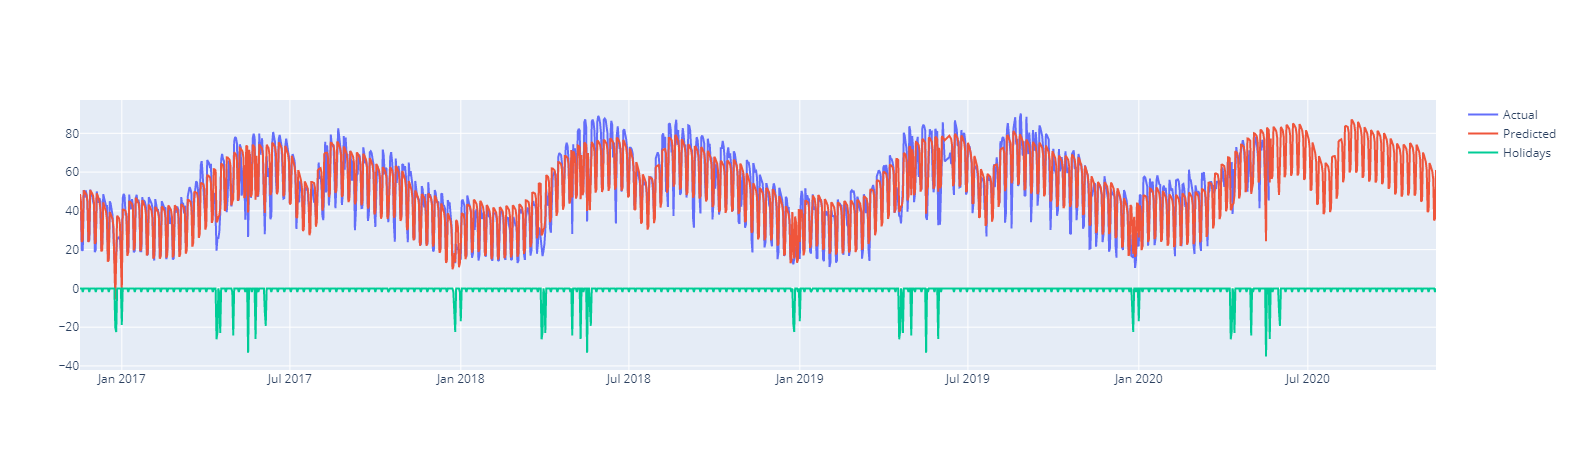

In [39]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.show()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


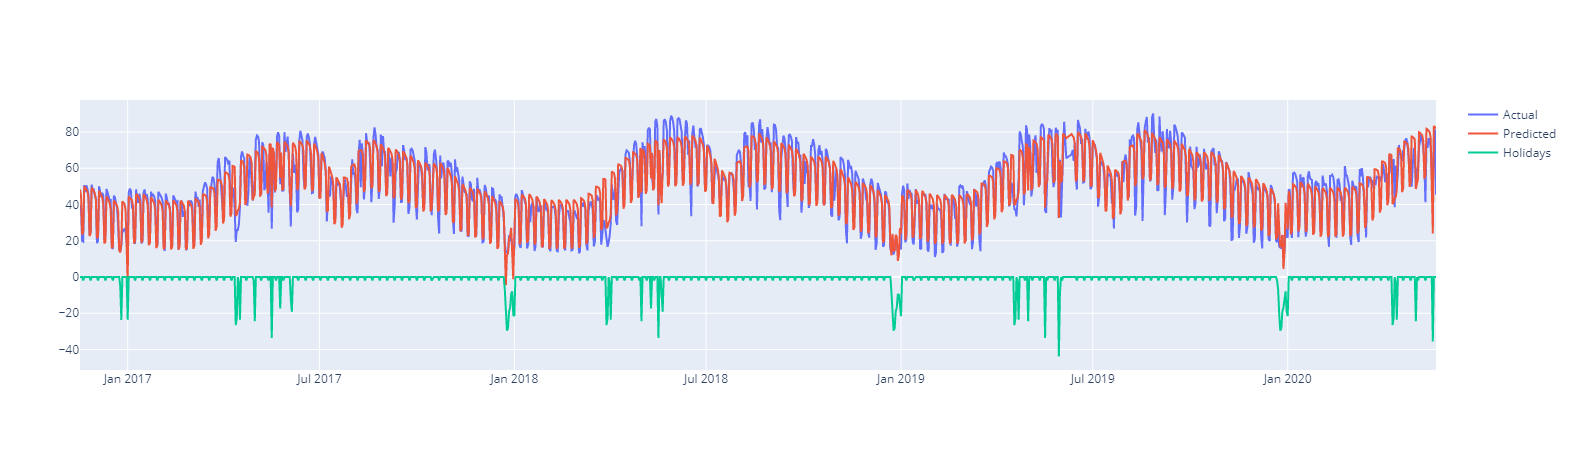

In [40]:
ascensionday = pd.DataFrame({
  'holiday': 'AscensionDay',
  'ds': pd.to_datetime(['2019-05-30']),
  'lower_window': 0,
  'upper_window': 1,
})

christmas = pd.DataFrame({
  'holiday': 'Christmas',
  'ds': pd.to_datetime(['2017-12-24','2018-12-24','2019-12-24','2020-12-24']),
  'lower_window': -1,
  'upper_window': 7,
})

holidays = pd.concat((ascensionday, christmas))

m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='NO')
m.fit(bikerides)
future = m.make_future_dataframe(periods=0, freq='D')
forecast = m.predict(future)

fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.show()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


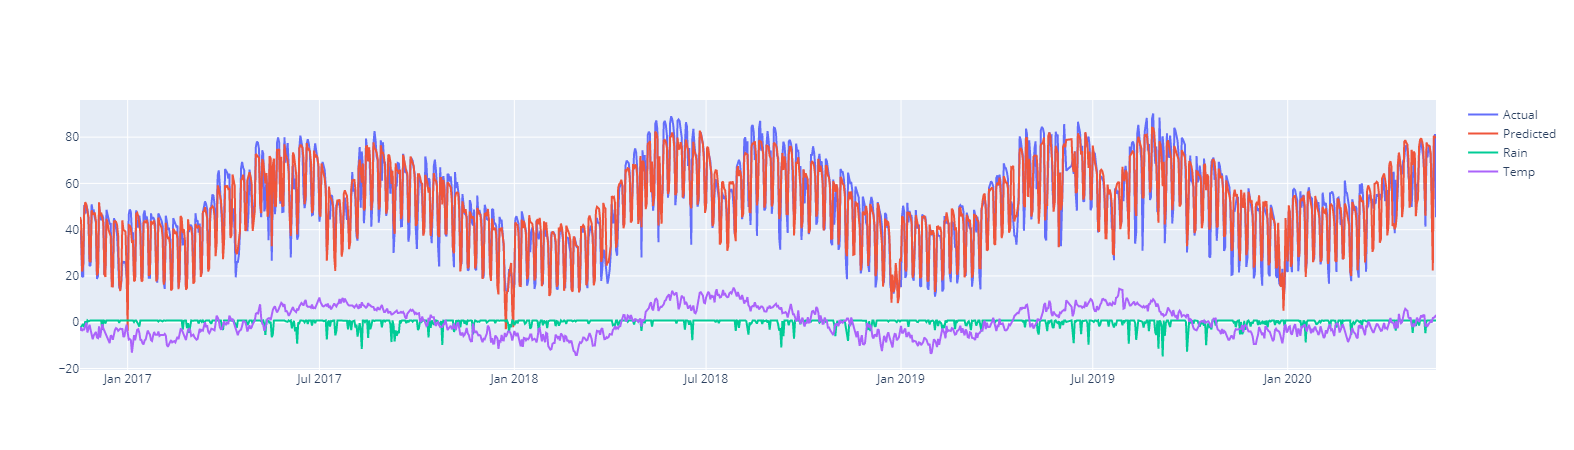

In [41]:
m = Prophet(holidays=holidays)
m.add_country_holidays(country_name='NO')
# Adding the extra weather regressors
m.add_regressor('rain')
m.add_regressor('temp')

m.fit(bikerides)
future = m.make_future_dataframe(periods=0, freq='D')
future = future.merge(bikerides, on='ds')
forecast = m.predict(future)
fig = go.Figure()

# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['rain'], name='Rain',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['temp'], name='Temp',))
fig.show()

In [42]:
getPerformanceMetrics(m).mean()

INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00


horizon     201 days 00:00:00
mse                    45.271
rmse                  6.67921
mae                   4.96659
mape                 0.115039
mdape               0.0729742
coverage             0.776137
dtype: object

In [43]:
def create_param_combinations(**param_dict):
    param_iter = itertools.product(*param_dict.values())
    params =[]
    for param in param_iter:
        params.append(param) 
    params_df = pd.DataFrame(params, columns=list(param_dict.keys()))
    return params_df

def single_cv_run(history_df, metrics, param_dict, parallel):
    m = Prophet(holidays=holidays, **param_dict)
    m.add_country_holidays(country_name='NO')
    # Adding the extra weather regressors
    m.add_regressor('rain')
    m.add_regressor('temp')
    m.fit(history_df)
    df_cv = getCrossValidationData(m)
    df_p = performance_metrics(df_cv, rolling_window=1)
    df_p['params'] = str(param_dict)
    df_p = df_p.loc[:, metrics]
    return df_p

#'changepoint_range': [0.6, 0.7, 0.75, 0.8, 0.9],
#'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.25, 0.5],
#'seasonality_prior_scale':[0.5, 1.0, 2.5, 5],
#'holidays_prior_scale':[1.0, 5.0, 10.0, 15.0],
#'yearly_seasonality':[5, 10, 15, 20],
#'weekly_seasonality':[5, 10, 15, 20],
pd.set_option('display.max_colwidth', None)
param_grid = {                  
                'changepoint_prior_scale': [0.01],
                'changepoint_range': [0.3],
                'holidays_prior_scale':[1.0],
                'seasonality_prior_scale':[0.5],
                'yearly_seasonality':[20],
                'weekly_seasonality':[5],
              }
metrics = ['horizon', 'rmse', 'mae', 'mape', 'mdape','params'] 
results = []

#Prophet(,)
params_df = create_param_combinations(**param_grid)
for param in params_df.values:
    param_dict = dict(zip(params_df.keys(), param))
    cv_df = single_cv_run(bikerides,  metrics, param_dict, parallel="processes")
    results.append(cv_df)
results_df = pd.concat(results).reset_index(drop=True)
best_param = results_df.loc[results_df['rmse'] == min(results_df['rmse']), ['params']]
print(f'\n The best param combination is {best_param.values[0][0]}')
results_df.mean()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00




 The best param combination is {'changepoint_prior_scale': 0.01, 'changepoint_range': 0.3, 'holidays_prior_scale': 1.0, 'seasonality_prior_scale': 0.5, 'yearly_seasonality': 20.0, 'weekly_seasonality': 5.0}


horizon    365 days 00:00:00
rmse                 6.96066
mae                  5.13406
mape                0.115393
mdape                0.07517
dtype: object

In [45]:
m = Prophet(holidays=holidays, changepoint_prior_scale=0.01,
            changepoint_range=0.8,
            seasonality_prior_scale=0.5,
            holidays_prior_scale=1.0,
            yearly_seasonality=20,
            weekly_seasonality=5,
            seasonality_mode='additive')

m.add_country_holidays(country_name='NO')
# Adding the extra weather regressors
m.add_regressor('rain')
m.add_regressor('temp')
    
m.fit(bikerides)
getPerformanceMetrics(m).mean()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00


horizon     201 days 00:00:00
mse                   45.7234
rmse                  6.72111
mae                   5.03999
mape                 0.112335
mdape               0.0734722
coverage             0.741004
dtype: object

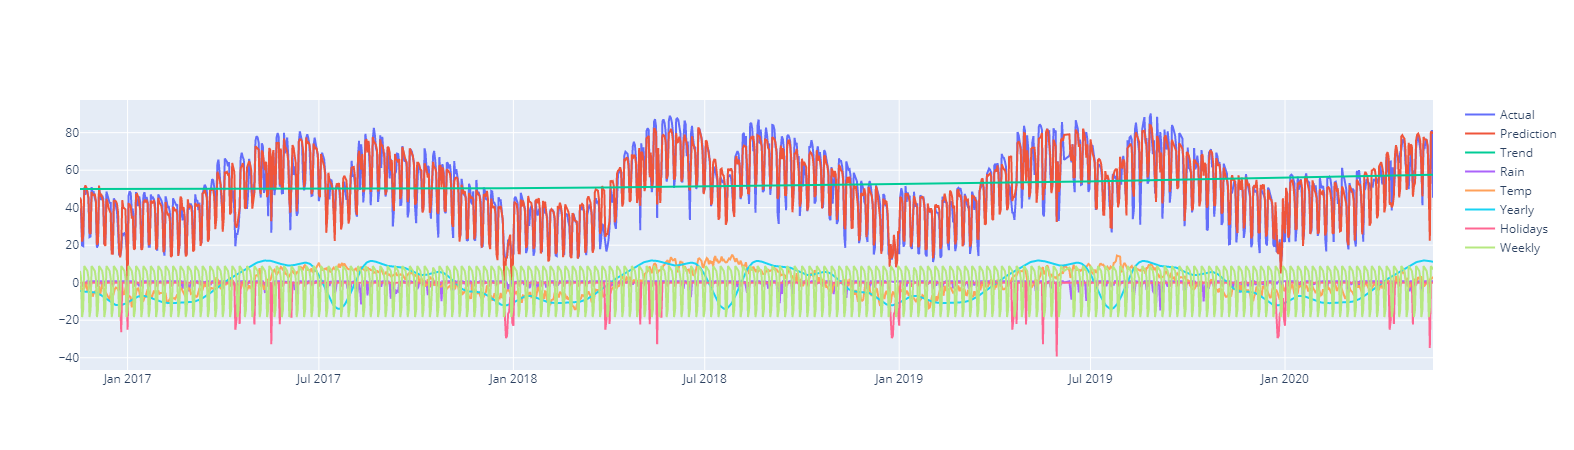

In [46]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Prediction',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['trend'], name='Trend',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['rain'], name='Rain',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['temp'], name='Temp',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yearly'], name='Yearly',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['weekly'], name='Weekly',))
fig.show()

In [47]:
# Let's get the sum of yhat (the prediction)
sum_yhat = forecast['yhat'].sum()
print('Forecast sum is:', sum_yhat)

sum_components = forecast['trend'].sum()+forecast['yearly'].sum()+ forecast['weekly'].sum()+forecast['holidays'].sum()+ forecast['extra_regressors_additive'].sum()
print('Sum of components is:', sum_components)
print('The model is equal to the sum of its components:', sum_yhat.round()==sum_components.round())

Forecast sum is: 64190.023261475246
Sum of components is: 64190.02326147525
The model is equal to the sum of its components: True


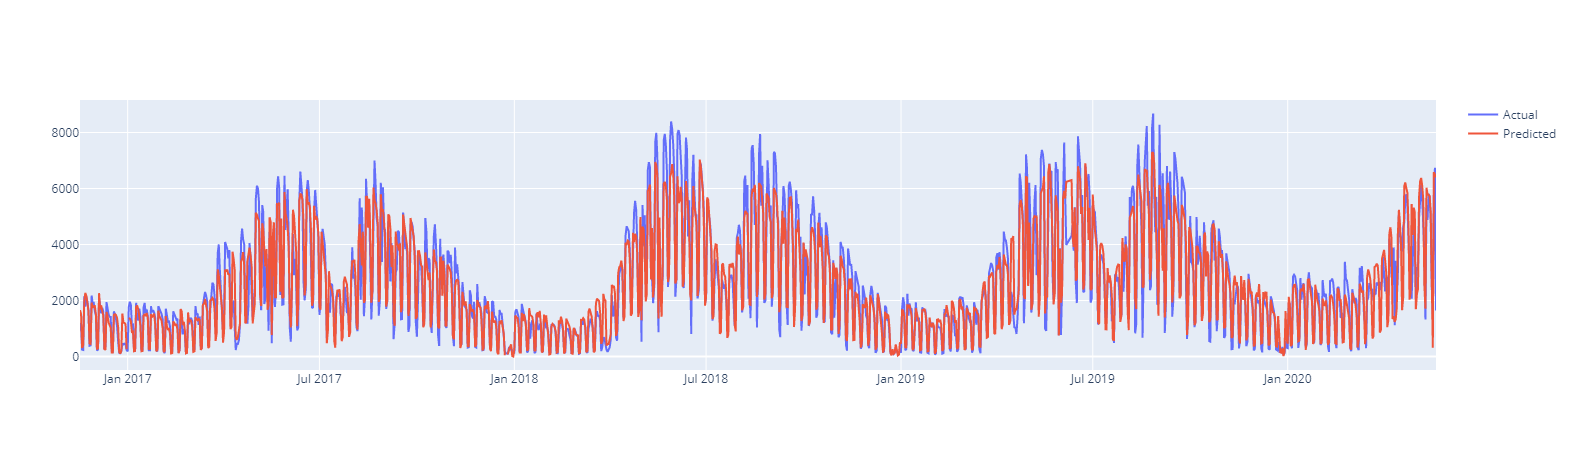

In [48]:

# Transform back to reality from Box Cox
forecast[['yhat','yhat_upper','yhat_lower']] = forecast[['yhat','yhat_upper','yhat_lower']].apply(lambda x: inv_boxcox(x, lam))
bikerides['y'] = inv_boxcox(bikerides['y'], lam)

# Plot the results
fig = go.Figure()
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.show()

In [59]:
getPerformanceMetrics(m).mean()

INFO:fbprophet:Making 6 forecasts with cutoffs between 2018-12-17 00:00:00 and 2019-05-21 00:00:00


horizon     201 days 00:00:00
mse                   45.7234
rmse                  6.72111
mae                   5.03999
mape                 0.112335
mdape               0.0734722
coverage              0.73853
dtype: object

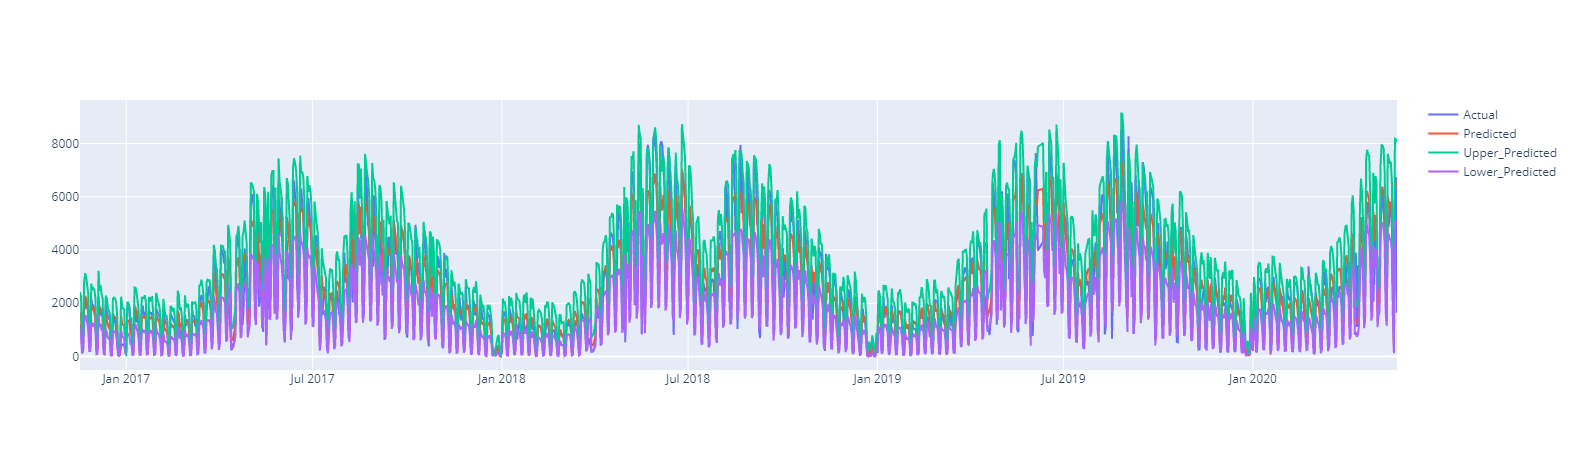

In [51]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=bikerides['ds'], y=bikerides['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_upper'], name='Upper_Predicted',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat_lower'], name='Lower_Predicted',))
fig.show()

<ipython-input-55-86a55fcb0861>:2: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.

<ipython-input-55-86a55fcb0861>:4: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



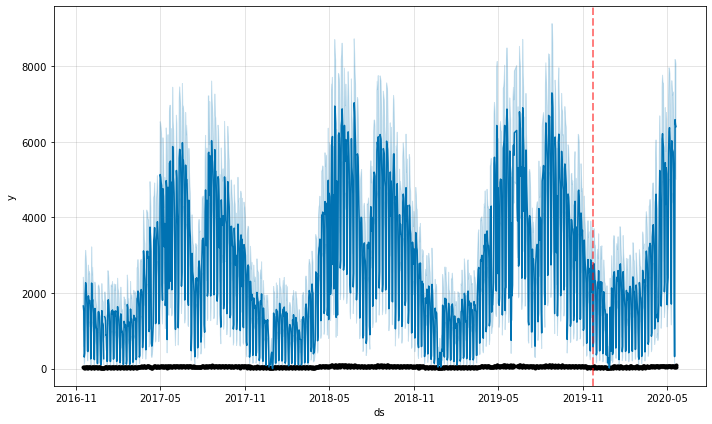

In [55]:
fig = m.plot(forecast)
ax = fig.add_subplot(111)
ax.axvline(x=forecast['ds'].max() - pd.Timedelta('180 days'), c='red', lw=2, alpha=0.5, ls='--')
fig.show()

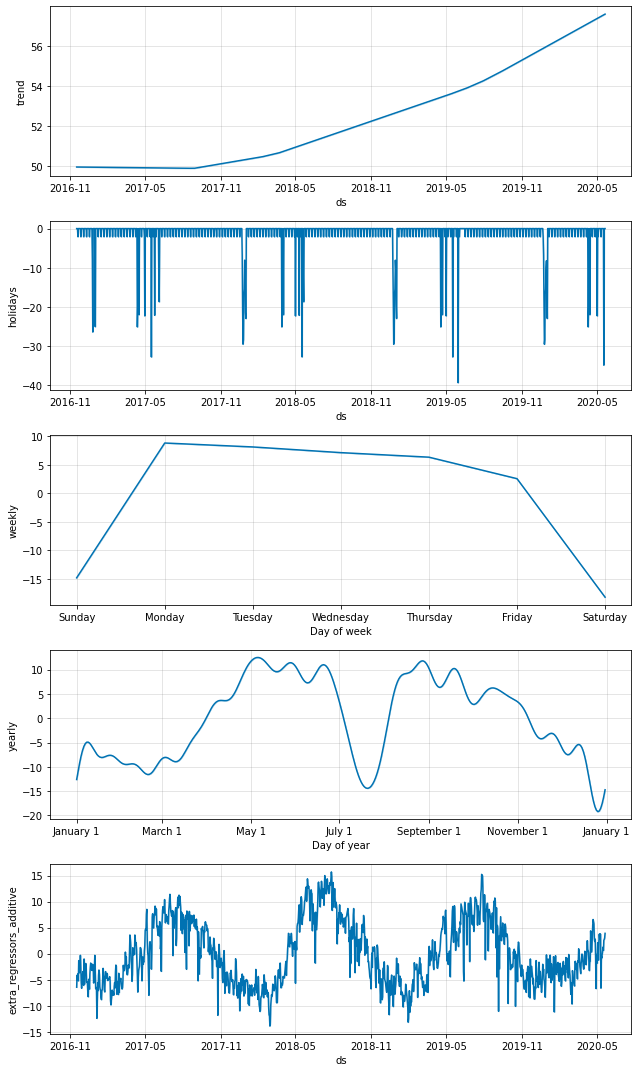

In [56]:
fig = m.plot_components(forecast)